# Configuration

In [13]:
# directory where MSD audio samples are stored (root directory)
MSD_SAMPLE_DIR                      = "/mnt/dataset_storage/audio/music/MSD/audio/"

# path to "msd_amglabels_all.h5" - leave blank to skip
MSD_AMG_TAGS_PATH                   = "/home/schindlera/experiments/representation_from_album_review/data/msd_amglabels_all.h5"

# Album Reviews - leave blank to skip
MSD_AMG_REVIEW_TRACKID_MAPPING_PATH = "/home/schindlera/experiments/representation_from_album_review/data/MSD_AMG_REVIEW_TRACKID_MAPPING.h5"

# directory to store intermediate and final results of the experiment
EXPERIMENT_DIR                      = "/home/schindlera/experiments/ismir2020_reviews/"

VALIDATION_SPLIT_PERCENTAGE         = 0.05

# Imports

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


# Load Data

## Find all MSD audio samples

In [3]:
sample_fullpaths = []
sample_track_ids = []

for root, dirs, files in os.walk(MSD_SAMPLE_DIR):
    for file in files:
        if file.endswith(".mp3"):
            sample_fullpaths.append(os.path.join(root, file))
            sample_track_ids.append(file.replace(".mp3", ""))

metadata_audio          = pd.DataFrame(sample_fullpaths, index=sample_track_ids, columns=["audio_path"])
metadata_audio["audio"] = True

print("%d MSD audio samples found" % metadata_audio.shape[0])

995000 MSD audio samples found


## Join with Tagset Data

In [11]:
if os.path.exists(MSD_AMG_TAGS_PATH):

    # load labelsets from hdf5 archive
    msd_amgtags_all         = pd.read_hdf(MSD_AMG_TAGS_PATH, "data")

    # only use instances where at least one genre tag is provided
    msd_amgtags_all         = msd_amgtags_all[~msd_amgtags_all.genres.isna()]
    msd_amgtags_all["tags"] = True

    # join with audio metadata
    metadata_final          = metadata_audio.join(msd_amgtags_all, how="inner")

    print("Intersection size: %d" % metadata_final.shape[0])
    
else:
    
    metadata_final = metadata_audio

Intersection size: 504992


## Join with Album Review Dataset

In [14]:
if os.path.exists(MSD_AMG_REVIEW_TRACKID_MAPPING_PATH):

    MSD_lastfmid_trackid_mapping            = pd.read_hdf(MSD_AMG_REVIEW_TRACKID_MAPPING_PATH, "data")
    MSD_lastfmid_trackid_mapping            = MSD_lastfmid_trackid_mapping.set_index("track_id")
    MSD_lastfmid_trackid_mapping["reviews"] = True

    metadata_final = metadata_final.join(MSD_lastfmid_trackid_mapping, how="inner")

    print("Intersection size: %d" % metadata_final.shape[0])

Intersection size: 249992


# Create Evaluation Partitions

## Util Functons

In [15]:
def get_least_frequent_genre(genre_list):

    vals = []

    for g in genre_list:

        g_idx = genre_frequencies.index.get_loc(g)

        vals.append([g_idx, g])

    vals = pd.DataFrame(vals, columns=["rank", "genre"]).sort_values("rank", ascending=False)
    
    return vals.iloc[0].genre

## Partition Data

### Pre-Process Labels to facilitate Stratification

### Original Distribution

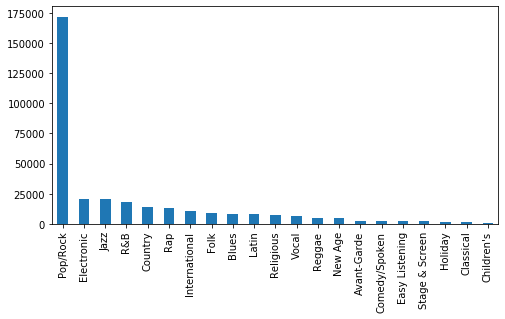

In [17]:
mlb = MultiLabelBinarizer()

experiment_genres = mlb.fit_transform(metadata_final.genres)
experiment_genres = pd.DataFrame(experiment_genres, index=metadata_final.index, columns=mlb.classes_)

genre_frequencies = experiment_genres.sum(axis=0).sort_values(ascending=False)
genre_frequencies.plot(kind='bar', figsize=(8,4));

## Flattened Distribution (only take least frequent tag)

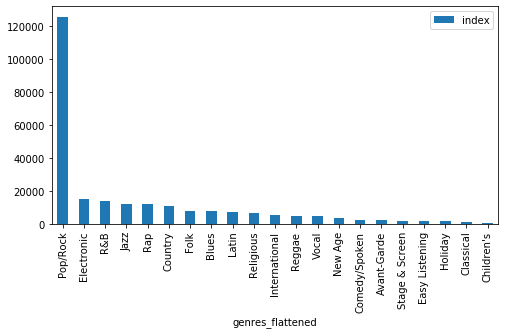

In [18]:
processed_genres         = metadata_final.genres.apply(lambda x: get_least_frequent_genre(x))
processed_genres         = pd.DataFrame(processed_genres)
processed_genres.columns = ["genres_flattened"]

processed_genres.reset_index().groupby("genres_flattened").count().sort_values("index", ascending=False).plot(kind='bar', figsize=(8,4));

In [19]:
# join processed genres with final metadata
assert(metadata_final.shape[0] == processed_genres.shape[0])

metadata_final = metadata_final.join(processed_genres)

# Create Partitions

Numerically encode labels

In [20]:
encoder = LabelEncoder()
encoder = encoder.fit(metadata_final.genres_flattened)

genres_encoded = encoder.transform(metadata_final.genres_flattened)

create train/validation splits

In [23]:
sss                = StratifiedShuffleSplit(n_splits=1, test_size=VALIDATION_SPLIT_PERCENTAGE, random_state=0)

idx_train, idx_val = list(sss.split(np.ones(genres_encoded.shape[0]), genres_encoded))[0]

idx_train.shape[0], idx_val.shape[0]

(237492, 12500)

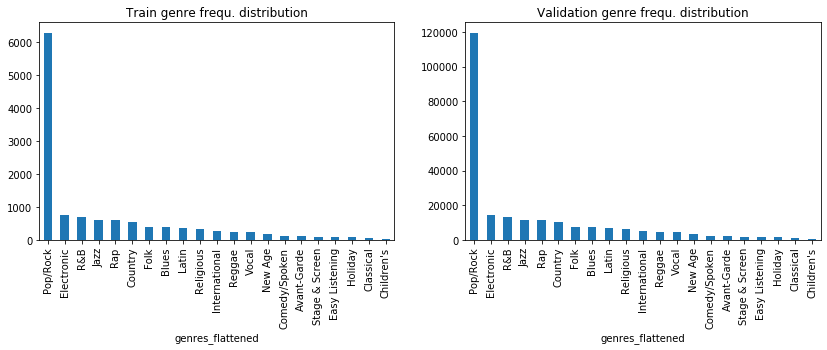

In [24]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
metadata_final.iloc[idx_val].reset_index().groupby("genres_flattened").count().sort_values("index", ascending=False).genres.plot(kind='bar', ax=ax1, title="Train genre frequ. distribution");
metadata_final.iloc[idx_train].reset_index().groupby("genres_flattened").count().sort_values("index", ascending=False).genres.plot(kind='bar', ax=ax2, title="Validation genre frequ. distribution");

Assign Partitions

In [25]:
metadata_final["train"] = False
metadata_final["val"]   = False

metadata_final.loc[metadata_final.iloc[idx_train].index, "train"] = True
metadata_final.loc[metadata_final.iloc[idx_val].index,   "val"]   = True

In [29]:
if not os.path.exists(EXPERIMENT_DIR):
    os.path.makedirs(EXPERIMENT_DIR)

In [28]:
metadata_final.to_hdf(EXPERIMENT_DIR + "/experiment_partition.h5", "data")

/home/schindlera/.conda/envs/base36/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['audio_path', 'genres', 'styles', 'moods', 'themes', 'artist_name',
       'title', 'release', 'genres_flattened'],
      dtype='object')]

  encoding=encoding,


# Create partition TrackID files for Feature extraction

Train Partition

In [34]:
metadata_final[metadata_final.train].reset_index()[["index"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_train.csv", header=None, index=None)

Validation Partition

In [35]:
metadata_final[metadata_final.val].reset_index()[["index"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_val.csv", header=None, index=None)